# The General Social Survey (GSS)

About Dataset
​​The GSS gathers data on contemporary American society in order to monitor and explain trends and constants in attitudes, behaviors, and attributes. Hundreds of trends have been tracked since 1972. In addition, since the GSS adopted questions from earlier surveys, trends can be followed for up to 70 years.

The GSS contains a standard core of demographic, behavioral, and attitudinal questions, plus topics of special interest. Among the topics covered are civil liberties, crime and violence, intergroup tolerance, morality, national spending priorities, psychological well-being, social mobility, and stress and traumatic events.

Altogether the GSS is the single best source for sociological and attitudinal trend data covering the United States. It allows researchers to examine the structure and functioning of society in general as well as the role played by relevant subgroups and to compare the United States to other nations. (Source)

This dataset is a csv version of the Cumulative Data File, a cross-sectional sample of the GSS from 1972-current.

https://www.kaggle.com/datasets/norc/general-social-survey?select=gss.csv

In [16]:
# Import packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Read in csv as a DataFrame and preview it
df = pd.read_csv('gss_sub.csv')
df

,year,id,labor_status,self_employed,marital_status,n_siblings,age,high_school,degree,political_affiliation,environment,law_enforcement,drugs,space_exploration,inequality,household_size
0,1972.0,1.0,WORKING FULLTIME,SOMEONE ELSE,NEVER MARRIED,3.0,23.0,16.0,BACHELOR,"IND,NEAR DEM",IAP,IAP,IAP,IAP,NaN,1.0
1,1972.0,2.0,RETIRED,SOMEONE ELSE,MARRIED,4.0,70.0,10.0,LT HIGH SCHOOL,NOT STR DEMOCRAT,IAP,IAP,IAP,IAP,NaN,2.0
2,1972.0,3.0,WORKING PARTTIME,SOMEONE ELSE,MARRIED,5.0,48.0,12.0,HIGH SCHOOL,INDEPENDENT,IAP,IAP,IAP,IAP,NaN,4.0
3,1972.0,4.0,WORKING FULLTIME,SOMEONE ELSE,MARRIED,5.0,27.0,17.0,BACHELOR,NOT STR DEMOCRAT,IAP,IAP,IAP,IAP,NaN,2.0
4,1972.0,5.0,KEEPING HOUSE,SOMEONE ELSE,MARRIED,2.0,61.0,12.0,HIGH SCHOOL,STRONG DEMOCRAT,IAP,IAP,IAP,IAP,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59594,2014.0,2539.0,KEEPING HOUSE,SOMEONE ELSE,WIDOWED,6.0,89.0,14.0,JUNIOR COLLEGE,NOT STR REPUBLICAN,TOO LITTLE,TOO LITTLE,TOO LITTLE,IAP,NaN,1.0
59595,2014.0,2540.0,WORKING FULLTIME,SOMEONE ELSE,DIVORCED,3.0,56.0,12.0,HIGH SCHOOL,INDEPENDENT,TOO LITTLE,TOO LITTLE,TOO MUCH,IAP,NaN,1.0
59596,2014.0,2541.0,WORKING FULLTIME,SOMEONE ELSE,NEVER MARRIED,5.0,24.0,14.0,HIGH SCHOOL,"IND,NEAR DEM",TOO LITTLE,ABOUT RIGHT,ABOUT RIGHT,IAP,NaN,3.0
59597,2014.0,2542.0,WORKING FULLTIME,SOMEONE ELSE,NEVER MARRIED,2.0,27.0,13.0,HIGH SCHOOL,NOT STR DEMOCRAT,IAP,IAP,IAP,IAP,NaN,2.0


## Data Validation and Cleaning


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   59599 non-null  float64
 1   id                     59599 non-null  float64
 2   labor_status           59583 non-null  object 
 3   self_employed          59306 non-null  object 
 4   marital_status         59575 non-null  object 
 5   n_siblings             56682 non-null  float64
 6   age                    59599 non-null  float64
 7   high_school            59440 non-null  float64
 8   degree                 59464 non-null  object 
 9   political_affiliation  59257 non-null  object 
 10  environment            59388 non-null  object 
 11  law_enforcement        59378 non-null  object 
 12  drugs                  59380 non-null  object 
 13  space_exploration      59596 non-null  object 
 14  inequality             1532 non-null   float64
 15  ho

Above we see that our DataFrame contains `float64` column (numerical data), as well as a number of `object` columns. Object data types contain strings.

### Inspecting individual columns


In [18]:
df['environment'].value_counts(normalize = True)

IAP            0.642268
TOO LITTLE     0.221981
ABOUT RIGHT    0.091685
TOO MUCH       0.028592
DK             0.015475
Name: environment, dtype: float64

## Manipulating categorical data
- The categorical variable type can be useful, especially here:
    - Save on memory when there are only a few different values.
    - You can specify a precise order to the categories when the default order may be incorrect (e.g., via alphabetical).
    - Can be compatible with other Python libraries.


In [19]:
# Create a dictionary of column and data type mappings
conversion_dict = {k: 'category' for k in df.select_dtypes(include='object').columns}
conversion_dict

# Convert our DataFrame and check the data types
df = df.astype(conversion_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   year                   59599 non-null  float64 
 1   id                     59599 non-null  float64 
 2   labor_status           59583 non-null  category
 3   self_employed          59306 non-null  category
 4   marital_status         59575 non-null  category
 5   n_siblings             56682 non-null  float64 
 6   age                    59599 non-null  float64 
 7   high_school            59440 non-null  float64 
 8   degree                 59464 non-null  category
 9   political_affiliation  59257 non-null  category
 10  environment            59388 non-null  category
 11  law_enforcement        59378 non-null  category
 12  drugs                  59380 non-null  category
 13  space_exploration      59596 non-null  category
 14  inequality             1532 non-null  

Already we can see that the memory usage of the DataFrame has been halved from 7 mb to 4 mb! This can help when working with large quantities of data, such as this survey that we'll be working with.

### Cleaning up the `labor_status` column

In [20]:
df['labor_status'].cat.categories

Index(['KEEPING HOUSE', 'OTHER', 'RETIRED', 'SCHOOL', 'TEMP NOT WORKING',
       'UNEMPL, LAID OFF', 'WORKING FULLTIME', 'WORKING PARTTIME'],
      dtype='object')

collapse some of these categories. The easiest way to do this is to replace the values inside the column using a dictionary, and then reset the data type back to a category.

In [21]:
# Create a dictionary of categories to collapse
new_labor_status = {"UNEMPL, LAID OFF": "UNEMPLOYED", 
                    "TEMP NOT WORKING": "UNEMPLOYED",
                    "WORKING FULLTIME": "EMPLOYED",
                    "WORKING PARTTIME": "EMPLOYED"
                   }

# Replace the values in the column and reset as a category
df['labor_status_clean'] = df['labor_status'].replace(new_labor_status).astype('category')

# Preview the new column
df['labor_status_clean'].value_counts()


EMPLOYED         35552
KEEPING HOUSE     9650
RETIRED           8102
UNEMPLOYED        3230
SCHOOL            1841
OTHER             1208
Name: labor_status_clean, dtype: int64

### Reordering categories

In [22]:
df['environment'].cat.categories

Index(['ABOUT RIGHT', 'DK', 'IAP', 'TOO LITTLE', 'TOO MUCH'], dtype='object')

Let's loop through the three variables and give them all an order. While we're at it, let's drop two categories that don't have any use for us: "DK" (don't know) and "IAP" (inapplicable). By removing them as categories, we set them to null so they won't be counted in the final analysis.

In [23]:
# Set the new order
new_order = ["TOO LITTLE", "ABOUT RIGHT", "TOO MUCH", "DK", "IAP"]
categories_to_remove = ["DK", "IAP"]

# Loop through each column
for col in ['environment', 'law_enforcement', 'drugs']:
    # Reorder and remove the categories
    df[col + '_clean'] = df[col].cat.reorder_categories(new_order, ordered=True)
    df[col + '_clean'] = df[col + '_clean'].cat.remove_categories(categories_to_remove)

# Preview one of the columns' categories
df['environment_clean'].value_counts(dropna=False)

NaN            39273
TOO LITTLE     13183
ABOUT RIGHT     5445
TOO MUCH        1698
Name: environment_clean, dtype: int64

Now let's also apply these steps to education level in one go: collapsing, removing, and reording.

In [24]:
# Define a dictionary to map old degree categories to new ones
new_degree = {"LT HIGH SCHOOL": "HIGH SCHOOL", 
              "BACHELOR": "COLLEGE/UNIVERSITY",
              "GRADUATE": "COLLEGE/UNIVERSITY",
              "JUNIOR COLLEGE": "COLLEGE/UNIVERSITY"}

# Replace old degree categories with new ones and convert to categorical data type
df['degree_clean'] = df['degree'].replace(new_degree).astype('category')

# Remove "DK" category from degree_clean column
df['degree_clean'] = df['degree_clean'].cat.remove_categories(['DK'])

# Reorder degree_clean categories and set as ordered
df['degree_clean'] = df['degree_clean'].cat.reorder_categories(['HIGH SCHOOL', "COLLEGE/UNIVERSITY"], ordered=True)

# Preview the new column
df['degree_clean'].value_counts(dropna=False)

HIGH SCHOOL           43553
COLLEGE/UNIVERSITY    15881
NaN                     165
Name: degree_clean, dtype: int64

### Let's simplify our dates data
We can also bin numerical data to create categorical variables. There are a few reasons that we might want to do this:
- It can simplify data and allow us to more easily spot trends and patterns.
- It can make visualizing data easier, such as when you want to use bar plots.


In [25]:
# Set the decade boundaries and labels
decade_boundaries = [(1970, 1979), (1979, 1989), (1989, 1999), (1999, 2009), (2009, 2019)]
decade_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']

# Set the bins and cut the DataFrame
bins = pd.IntervalIndex.from_tuples(decade_boundaries)
df['decade'] = pd.cut(df['year'],bins)

# Rename the categories
df['decade'].cat.rename_categories(decade_labels, inplace=True)

# Preview the new column
df[["year", "decade"]]

,year,decade
0,1972.0,1970s
1,1972.0,1970s
2,1972.0,1970s
3,1972.0,1970s
4,1972.0,1970s
...,...,...
59594,2014.0,2010s
59595,2014.0,2010s
59596,2014.0,2010s
59597,2014.0,2010s


## Visualizing categorical variables

### Bar plots to show value counts

In [27]:
# Create a new figure object
fig = px.bar(df['labor_status_clean'].value_counts(),
            template='plotly_white')

# Hide the legend
fig.update_layout(showlegend=False)

# Show the plot
fig.show()

In [28]:
# Create a new figure object
fig = px.bar(df['labor_status_clean'].value_counts(ascending=True),
            template='plotly_white',
            orientation='h',
            title='Labor Status by count')

# Hide the legend
fig.update_layout(showlegend=False)

# Show the plot
fig.show()


### Bar charts to show a categorical average


In [32]:
# Aggregate household size by year
household_by_decade = df.groupby(['decade','degree_clean'], as_index=False)['household_size'].mean()
household_by_decade

,decade,degree_clean,household_size
0,1970s,HIGH SCHOOL,3.269804
1,1970s,COLLEGE/UNIVERSITY,3.033561
2,1980s,HIGH SCHOOL,2.773620
3,1980s,COLLEGE/UNIVERSITY,2.609780
4,1990s,HIGH SCHOOL,2.567347
5,1990s,COLLEGE/UNIVERSITY,2.492244
6,2000s,HIGH SCHOOL,2.495044
7,2000s,COLLEGE/UNIVERSITY,2.399721
8,2010s,HIGH SCHOOL,2.474694
9,2010s,COLLEGE/UNIVERSITY,2.297444


In [38]:
# Create a new figure object
fig =px.bar(household_by_decade,
           x='decade',
           y='household_size',
            color='degree_clean',
           template='plotly_white',
           title='Average household size by decade',
           barmode='group')




# Show the plot
fig.show()

### Boxplots


In [44]:
# Create a new figure object
fig = px.box(df,
           x='age',
           y='labor_status_clean',
           template='plotly_white')

# Show the plot
fig.show()

### Mosaic plots

In [46]:
pd.crosstab(df['degree_clean'], df['law_enforcement_clean'])

law_enforcement_clean,TOO LITTLE,ABOUT RIGHT,TOO MUCH
degree_clean,,,
HIGH SCHOOL,8063,4879,1340
COLLEGE/UNIVERSITY,3230,2635,428


However, this can be hard to interpret, as it's not easy to get a sense of the proportions within the two categories. A better way to represent this data is a mosaic plot. Mosaic plots display the proportion of each category within each level of the other variable. This allows us to easily compare the distribution of the two variables. 

Mosaic plots are difficult to generate in Plotly, but fortunately `statsmodels` has a [`mosaic`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html) function that makes generating them a breeze.

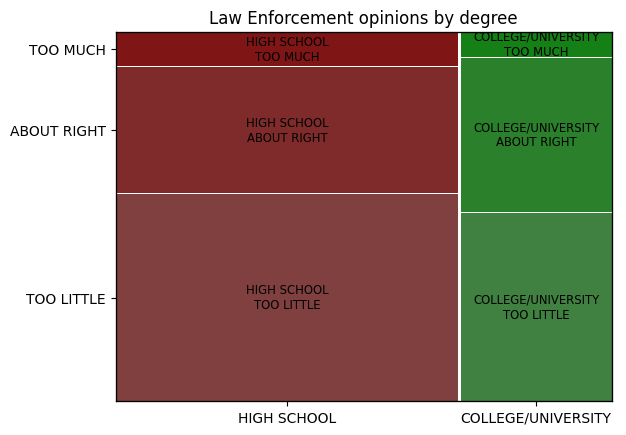

In [47]:
# Create a mosaic plot and show it
mosaic(df,['degree_clean', 'law_enforcement_clean'], title='Law Enforcement opinions by degree')
plt.show()


### Line charts

In [50]:
# Group the dataframe by year and marital status, and calculate the normalized value counts
marital_rates =df.groupby(['year'], as_index=False)['marital_status'].value_counts(normalize=True)

# Display the resulting DataFrame
marital_rates

,year,marital_status,proportion
0,1972.0,MARRIED,0.719157
1,1972.0,NEVER MARRIED,0.130192
2,1972.0,WIDOWED,0.086175
3,1972.0,DIVORCED,0.040298
4,1972.0,SEPARATED,0.024179
...,...,...,...
145,2014.0,MARRIED,0.456985
146,2014.0,NEVER MARRIED,0.266377
147,2014.0,DIVORCED,0.162194
148,2014.0,WIDOWED,0.082478


In [51]:
# Create a new figure object
fig = px.line(marital_rates,
             x='year',
             y='proportion',
             color='marital_status',
             template='plotly_white')



# Update the y-axis to show percentages
fig.update_yaxes(tickformat='.0%')

# Show the plot
fig.show()